In [1]:
import numpy as np
import pandas as pd
import itertools
import pulp
from matplotlib import pyplot as plt

In [2]:
#  customer count ('0' is depot) 
customer_count = 9

# the number of vehicle
vehicle_count = 6

# Maximum allowable time
Tmax = 10

# fix random seed
p=np.random.seed(seed=777)

In [3]:
df =pd.read_csv('Profit Matrix.csv')
df

,1,2,3,4,5,6,7,8,9
0,0,52,11,3,25,14,39,11,20
1,52,0,44,54,33,55,20,46,36
2,11,44,0,13,17,18,30,3,17
3,3,54,13,0,26,16,41,12,19
4,25,33,17,26,0,33,23,19,26
5,14,55,18,16,33,0,42,16,20
6,39,20,30,41,23,42,0,33,24
7,11,46,3,12,19,16,33,0,14
8,20,36,17,19,26,20,24,14,0


In [4]:
ds =pd.read_csv('Time Matrix.csv ')
ds

,0,1,2,3,4,5,6,7,8
0,0,5,4,8,6,4,2,7,3
1,5,0,7,6,9,1,2,5,8
2,4,7,0,3,4,6,8,3,4
3,8,6,3,0,3,8,6,4,8
4,6,9,4,3,0,3,8,4,6
5,4,1,6,8,3,0,5,4,5
6,2,2,8,6,8,5,0,7,5
7,7,5,3,4,4,4,7,0,7
8,3,8,4,8,6,5,5,7,0


In [5]:
# solve with pulp
for vehicle_count in range(1,vehicle_count+1):
    
    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMaximize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
    

    # add objective function
    problem += pulp.lpSum(df.iloc[i][0] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count) 
                          for j in range(customer_count) 
                          for i in range (customer_count))

    # constraints
    
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                              for i in range(customer_count) 
                              for k in range(vehicle_count)) == 1 

   
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    
    for k in range(vehicle_count):
        problem += pulp.lpSum(ds.iloc[i][j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= Tmax


    
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1
    
    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Total Profit:', pulp.value(problem.objective))
        break

Vehicle Requirements: 3
Total Profit: 175


In [6]:
dis_mat=pd.read_csv("lat-long.csv")
dis_mat

,latitude,longitude
0,25.263334,82.993229
1,25.371025,83.025501
2,25.285997,83.000095
3,25.264886,82.984303
4,25.308785,83.009307
5,25.256331,82.974142
6,25.335728,82.977182
7,25.282510,82.997773
8,25.298069,82.970295


In [7]:
color=["purple","blue","yellow","green"]

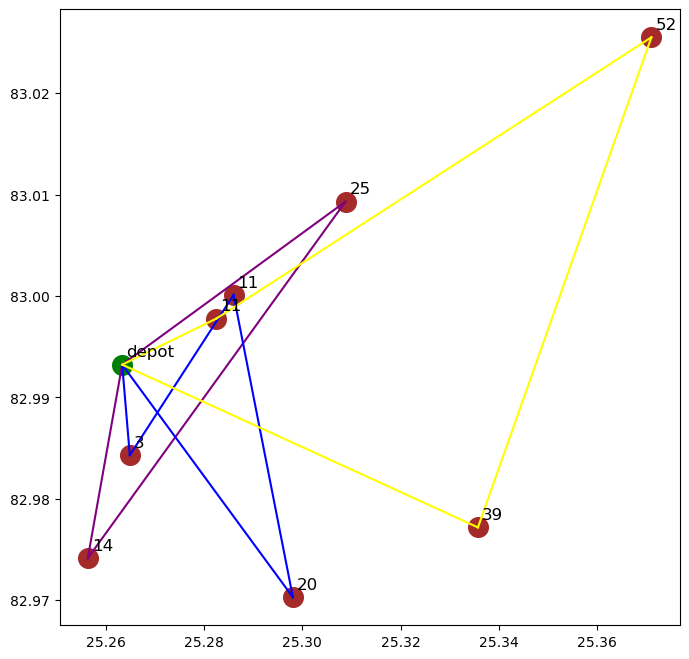

In [8]:
# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(dis_mat.latitude[i], dis_mat.longitude[i], c='green', s=200)
        plt.text(dis_mat.latitude[i]+0.0008, dis_mat.longitude[i]+0.0008, "depot", fontsize=12)
    else:
        plt.scatter(dis_mat.latitude[i], dis_mat.longitude[i], c='brown', s=200)
        plt.text(dis_mat.latitude[i]+0.0008, dis_mat.longitude[i]+0.0008, str(df.iloc[i][0]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([dis_mat.latitude[i], dis_mat.latitude[j]], [dis_mat.longitude[i], dis_mat.longitude[j]], c=color[k])

plt.show()